# Abstract
In this project we investigated the sentiment regardning the presidential candidates of the US election 2020, Joeseph R Biden and Donald J Trump, on Twitter. The social media plattform Twitter is and has been highly influential on the policatal debate and elections in the US. We have retrevied a large dataset consisting of 1.7 million tweets with hashtags related to the candidates from the Data Science community Kaggle. The tweets were posted during October 15th to November 8th 2020.

We clustered the data into 6 groups based on user follower count and hashtag. We then analysed the sentiment of the tweets using the model VADER (Valence Aware Dictionary for Sentiment Reasoning). 

Our analysis indicated that the sentiment on Twitter were similarly distributed in all clusters for the two candidates. For both candidates the sentiment was more positive for users with high amounts of followers (>30 000).

In [1]:
# LOAD PACKAGES
from client.api.notebook import Notebook
import os
import string
import time
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
import nltk
from IPython.display import clear_output
from sklearn.cluster import KMeans
from graphviz import Source
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import graphviz
pd.options.mode.chained_assignment = None  # default='warn'
print('Go to go!')

Go to go!


In [2]:
#### RUN ONLY IN GOOGLE COLAB ####
# Install needed packages
!pip install kaggle
!mkdir ~/.kaggle 
%load_ext google.colab.data_table

# Import packages
from google.colab import data_table

# Kaggle API Key
!echo '{"username":"svantepihl","key":"294e719d5da4fffa993782c856e0a64d"}' > ~/.kaggle/kaggle.json
clear_output()
print('Go to go!')

Go to go!


# Data mining project




## 1. Background

The organization we have chosen for this project is The Democratic Party in the US and the case is fictional. The Democratic Party was formed 1828 due to dissatisfaction with the central power of George Washington. The party dominated between 1829-1860. The democrats were divided on the issue of slavery and the result was that President Lincoln won and their 30 years long dominants in politics disappeared (Eliasson & Stranne n.d.).  

After the civil war the Democratic Party was seen as conservative and had difficulty gaining power. In 70 years, they won the presidential election only four times. The turning point was when Franklin D. Roosevelt was elected president. The party changed their politics to create a social and welfare state. This resulted in a change in their voter base and southern voters with a conservative view switched to Republicans. The democrats have been continuing with this politics to this day (Eliasson & Stranne n.d.).  

For the 2020 election, the Democrats nominated Joe Biden for president and The Republicans nominated Donald J. Trump. It was a tight race between the two presidential candidates (BBC 2020) and after days of voting, the primary result of the election shows that the people of the USA have chosen Joe Biden as their new president (Collinson & Reston 2020).  

Based on interviews we have had with the Democrats, we understand that they find it difficult to reach voters on social media, especially on Twitter. They want to have information about the popularity of tweets regarding Biden and Trump. By observations on Twitter, Trump has more followers than Joe Biden which makes it easier for Trump to reach voters. Therefore they want our help to analyze how popular tweets regarding the 2020 presidential election have a positive or negative tone to Joe Biden. By analyzing tweets we hope to help Democrats to reach out more to voters on Twitter.   



# 2. Problem description and research questions

## 2.1 Problem description

Social media has changed how we communicate and interact with one another but also our access to news. Twitter has over 348 millions active users that create over 500 millions tweets a day. Due to the popularity of the service, people are able to create trends that affect which news that will be reported the most. Because of the growing use, Twitter has become a critical communication tool for election campaigns. This kind of campaigning has increased in the last decade and politicians and political parties are “micro-blogging” their messages. The interest for researchers have also been increasing, election predictions based on Twitter data are a popular research area (Atluri V et al. 2020).  

Politics can communicate through social media two ways: party centric och individually targeted. By micro-blogging politicians can reach out to their audience personally and engage voters, create opinions, and publish information. If the voters respond to the information, they will most likely contact the politicians and attend events. This is one of many reasons why politicians use social media as their platform to communicate with their voters (Dwivedi Y.K et al. 2019).  

We’ve formed a fiction scenario for our data mining project. The Democratic Party in the US has been facing surprises and disappointments in recent years, and therefore want to know more about their voter base and how to get other political voters to vote for them. By doing so, the Democratic Party wishes to examine the outcome of the presidential election 2020 in relation to Twitter data. Specifically, the democrats would like to know whether the support on Twitter for the respective political parties differ based on users’ tweet popularity.  

The results will be useful to the Democratic Party in future elections. Gaining knowledge about user sentiment in relation to popularity on Twitter is important in order to plan the electoral campaigns. Being aware of what users tend to be supportive of a certain presidential candidate determines where campaigning and presidential visit is of the most importance.  

The Democrats have initialized a project and hired an external group to preprocess twitter data from users that mentions the election and/or the political parties in their tweets. The task is to preprocess the retrieved data set containing information about 120 000 tweets from users in the US. We’ll also use data mining methods such as clustering to detect patterns in user sentiment and tweet popularity. 

## 2.2 Research question
Based on the problem description above, our research question is:  

*How does sentiment on Twitter regarding the presidential candidates of the US Election 2020 differ when we cluster based on tweet popularity in the US?*

We define popularity by how many followers the user has.


## 2.3 Hypothesis
To answer the question above, we believe that positive tweets regarding Trump have a greater tendency to be more popular than popular positive tweets regarding Biden. We draw that conclusion because we believe that Trump’s voter base is more active on Twitter and are receptive to twitter information. Trump has created a whole new way to reach out to the audience and Biden hasn’t been as fast to catch on to this new trend. 

# 3. Previous studies and related research 

The usage of Twitter by politicians and campaigning has become a highly popular research area. This is because of the interest in understanding the platform’s importance in campaigns. By using social media, political actors and state institutions are provided a simple and low cost platform for reaching out to the public. Among the social media platforms of today, Twitter has become the most popular in terms of sharing information. For example, it’s being used by city governments to raise awareness and generate sentiment in a fast and cost effective way (Nooralahzadeh et al. 2013).  
 
Twitter sentiment analysis is a method used in several areas in relation to governance and public opinion, identifying public opinion for instance (Nooralahzadeh, Arunachalam & Chiru, 2013). Nooralahzadeh et al. (2013) conducted a time series analysis where user tweets were examined in order to gain insights on the outcome of the US and France elections in 2012. In addition to this they also conducted a word cloud and hashtag analysis on the candidates and discussed topics to compare the two elections.   

One study investigates the citizen participation in the political discussion occurring on Twitter during the US election in 2016 by analyzing the users’ sentiment and behavior. To do so, they employed a data analytics approach and collected over 3 million tweets for three weeks around the time of the election. The study aimed to examine if the contents of the tweets indicate users’ sentiment and opinion, and if the topics reflect important real-life events. They also estimate the sentiments of the candidates’ tweets during their campaigns and evaluate their impact on the overall sentiment of election-related discussion topics on Twitter (Yaquba et al. 2017).  

Related research also examines the information spread on social media platforms and the effect sentiment has. It has shown that sentiment has a great effect on information spread on Twitter. Some studies even say that a positivity bias exists in the spread of information. Positive tweets have a higher retweet rate and are spread to a wider audience in comparison to negative tweets (Ferrara & Yang, 2015a; Ferrara & Yang, 2015b).

Findings from related studies will be helpful when evaluating the results from the data collection process. We conduct a sentiment analysis for our study when analyzing our pre-processed dataset, presented in ”Analysis of political discourse on twitter in the context of the 2016 US presidential elections”. Similar methods for sentiment classification of Twitter data can be found in several scientific papers and will be discussed further in this paper.



# 4. Data collection, Preprocessing & Exploratory analysis 

## 4.1 Data collection
The dataset on which our analysis is based comes from the online data science community [Kaggle](https://kaggle.com), a subsidiary of Google LLC.

The dataset was gathered and uploaded to Kaggle by the user Manch Hui, it can be found [here](https://www.kaggle.com/manchunhui/us-election-2020-tweets). The dataset was gathered by using the Twitter API and a scraping tool called 'snscrape'. As of writing (11 November 2020) the dataset consists of 1 727 000 tweets. All tweets in the dataset added beacause they contain at least one of the following hashtags:

> #JoeBiden
> #Biden
> #DonaldTrump
> #Trump

We start with downloading the ZIP-file containing the latest version of the  dataset from kaggle.






In [ ]:
#### RUN ONLY IN GOOGLE COLAB ####

# Download data from Kaggle using the Kaggle package
!kaggle datasets download -d "manchunhui/us-election-2020-tweets" -p /content/data/
while not os.path.exists("/content/data/us-election-2020-tweets.zip"):
  time.sleep(1)
if os.path.isfile("/content/data/us-election-2020-tweets.zip"):
  !unzip /content/data/us-election-2020-tweets.zip -d "/content/data/"
clear_output()
print("CSV files are ready!")

us-election-2020-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/data/us-election-2020-tweets.zip
replace /content/data/hashtag_donaldtrump.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Let's read the CSV files into dataframes and take a first look at our dataset to see what we have to work with!

In [ ]:
#### RUN ONLY IN GOOGLE COLAB ####

# Read into dataframes and add coloumn to indicate which hashtag the tweet is related to
tweets_trump = pd.read_csv('/content/data/hashtag_donaldtrump.csv', lineterminator='\n')
tweets_trump['hashtag'] = "trump"

tweets_biden = pd.read_csv('/content/data/hashtag_joebiden.csv', lineterminator='\n')
tweets_biden['hashtag'] = 'biden'

# Combine into one dataframe
tweets_all = tweets_trump.append(tweets_biden, ignore_index=True)

# Sort by date created
tweets_all.sort_values(by='created_at')

# Remove duplicates
tweets_all.drop_duplicates()

# Print overview
tweets_all.info(null_counts=True, verbose=True)

In [ ]:
## RUN IF OUTSIDE OF GOOGLE COLAB ##
#tweets_all = pd.read_csv("data/tweets_all.csv", lineterminator='\n')
#tweets_all.info(null_counts=True, verbose=True)

# Print overview
#tweets_all.info(null_counts=True, verbose=True)

As it stands, our dataset contains 1747805 rows and 21 columns. The variables that are that are available to us are the following:


>*   created_at: Date and time of tweet creation
>*   tweet_id: Unique ID of the tweet
>*   tweet: Full tweet text
>*   likes: Number of likes
>*   retweet_count: Number of retweets
>*   source: Utility used to post tweet
>*   user_id: User ID of tweet creator
>*   user_name: Username of tweet creator
>*   user_screen_name: Screen name of tweet creator
>*   user_description: Description of self by tweet creator
>*   user_join_date: Join date of tweet creator
>*   user_followers_count: Followers count on tweet creator
>*   user_location: Location given on tweet creator's profile
>*   lat: Latitude parsed from user_location
>*   long: Longitude parsed from user_location
>*   city: City parsed from user_location
>*   country: Country parsed from user_location
>*   state: State parsed from user_location
>*   state_code: State code parsed from user_location
>*   collected_at: Date and time tweet data was mined from twitter
>*   hashtag: Under which hashtag the tweet was added to dataset under, trump or biden.

Below we present a table that you can explore the data with.

In [ ]:
# View data
tweets_all.head(1000)

We notice that alot of our tweets are from user located all over the world. For our analysis we are only interested in user from inside the US, because of that we will select only tweets where the user's location is inside the US. We recognize that will also discard tweets from the US but where the location information is missing but it's choice we are ready to make for the purposes of our analysis. We also recognize that the 'user_location' column is based on what the twitter has themself put on their profile and a such can contain for example:multiple locations and nonsensical location. Something we will discuss later on in our analysis.

We are also gonna remove the following coloumns, as they are not needed for this study: 
>*   tweet_id
>*   lat
>*   long
>*   country
>*   continent
>*   state
>*   state_code
>*   collected_at

We also want to create a column that contains how old the user account was when the tweet was created, which we will call "account_age".




In [ ]:
# Drop unnecessary columns
tweets_all = tweets_all.drop(columns=['tweet_id', 'lat','long','city','country','continent','state','state_code','collected_at'])

# Different strings that indicates that the user is from the US
US_options = ['USA', 'United States of America', 'Land of the free','America','the us']
# Simple function that checks if any of the above options is containted in the string
def contains_option(location):
  result = False
  if any(option.lower() in location.lower() for option in US_options):
    result = True
  return result

# Remove all rows where user location is missing
tweets_all = tweets_all.dropna(subset=['user_location'])

tweets_all = tweets_all[tweets_all['user_location'].apply(contains_option)] 

# Add column with account age
# Function to calcuate difference in days
def days_between(str1,str2):
  date1 = datetime.strptime(str1, '%Y-%m-%d %H:%M:%S')
  date2 = datetime.strptime(str2, '%Y-%m-%d %H:%M:%S')
  delta = date1 - date2
  return delta.days

# Create column
tweets_all['account_age'] = tweets_all.apply(lambda x: days_between(x['created_at'], x['user_join_date']), axis=1)



In [ ]:
#Print info about dataset
tweets_all.info(null_counts=True)

In [ ]:
# View data
tweets_all.head(1000)

So far we have taken the following steps to 'clean' our data:

*   Removed all rows where the user's location was missing.
*   Selected only rows where the user's location was in the US.
*   Removed unnecessary columns e.g. 'tweet_id' and 'continent'
*   Created a new column containing age of the user's twitter account in days when the tweet was posted. Calculated based on the columns 'created_at' and 'user_join_date'.

Left in our dataset we have 119146 rows and 14 columns. The dataset was of very high quality and currently only two columns contains any null values,'source' and 'user_description', and those columns we do not believe will be important for our analysis, but might me interesting to keep around.

Next up we will start preprocessing on the text in the tweets.


## 4.2 Tweet preprocessing

In this section we will processing the text contained in the tweets in our dataset. We begin with extracting all hashtags from tweets using RegEx.

In [ ]:
import re
tweets_all['all_hashtags'] = tweets_all['tweet'].apply(lambda x: re.findall(r'#(\w+)', x))
tweets_all.head(3)

After that we use the twitter preprocessing package [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/) which will help us deal with the following: 


*   Mentions
*   URLs
*   Reserved words (e.g RT and FAV)
*   Emojis



In [ ]:
# Installation & import
!pip install tweet-preprocessor

import preprocessor as p
# Create new column
tweets_all['cleaned_tweet'] = tweets_all['tweet'].apply(lambda x: p.clean(x))
#Remove links from original tweets
p.set_options(p.OPT.URL)
tweets_all['tweet'] = tweets_all['tweet'].apply(lambda x: p.clean(x))
p.set_options()
tweets_all.head(30000)

So after running the clean command from 'tweet-preprocessor' all mentions, links, emojis and reserved words have been removed. We continue with making all text lowercase and removing digits and punctuation. 

In [ ]:
# Make all text lowercase
tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda s: s.lower())

# Remove all digits
tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda s: re.sub(r'[0-9]', '', s))

# Remove puncutiation
tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

tweets_all.head(10)

Next up, let's tokenize the cleaned tweets into lists of words.

In [ ]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda s: tweet_tokenizer.tokenize(s))
tweets_all.head(10)

Lemmatization is the precess of grouping inflected forms of words together so that they can be analysed together. This are identified by their lemma (dictionary form) and hence the name. For example 'working' and 'worked' would be identified together as 'work. This feature is provided by the NLTK package.

In [ ]:
# Import
nltk.download
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


lemmatizer = WordNetLemmatizer()

def lemmatize_list(list):
  return [(lemmatizer.lemmatize(w)) for w in list]

tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda l: lemmatize_list(l))


In [ ]:
tweets_all.head(10)

Let's also remove all words that are shorter than 3 characters.

In [ ]:
def remove_short_words(list):
  result = []
  for word in list:
    if len(word) > 2:
      result.append(word)
  return result

tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda l: remove_short_words(l) )
tweets_all.head(10)

Next we remove common stop words from our lists of word, again using the popular NLTK package.

In [ ]:
nltk.download
nltk.download('stopwords')
from nltk.corpus import stopwords

def remove_stopwords(tokens,stopwords):
  filtered_tokens = [token for token in tokens if token not in stopwords]
  return filtered_tokens

tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda l: remove_stopwords(l,stopwords.words('english')))

Let's calculate the top words in our corpus to see if there are any additional words we would want to add to our stoplist.

In [ ]:
import collections
def top_words(corpus):
    word_count = collections.Counter()

    for words in corpus:
        word_count.update(words)
    dictionary = {key: value for (key, value) in word_count.items() if value >= 1}
    return pd.DataFrame.from_dict(dictionary,orient='index',columns=['Count']).sort_values(by='Count', ascending=False)

top_list = (top_words(tweets_all.cleaned_tweet))



In [ ]:
top_list.head(50)

In [ ]:
# We add some addtional stop words that we identify from the list above.
additional_stopwords = ['like','doe','back','cant','amp','get','dont','know','say','one','want','need','doesnt','would','year','time','day','make','going','think','let','via','see','said','even','never','new','way','many','look','thats','still']

tweets_all.cleaned_tweet = tweets_all.cleaned_tweet.apply(lambda l: remove_stopwords(l,additional_stopwords))
top_list = (top_words(tweets_all.cleaned_tweet))
top_list.head(50)

# 5 Data Mining Methods
In this section we will describe the methods we will apply when conducting our analysis

## 5.1 Cluster Analysis
To analyze our data we have chosen to use Cluster Analysis, and the method describes the group data objects and their relationships. The goal is to find objects that are similar to each other within the group and groups that are different to other groups. The greater the similarity the objects are in the group and the greater the difference between the groups, the better or more clear the clustering. Cluster Analysis is often referred to as unsupervised classification, and the reason for that is that clustering automatically divides data into clustering or groups without knowing how the groups should look in advance (Kumar V et. al, 2019). 

#### 5.1.1 K-means 
K-means is a prototype-based method and defines a prototype in the shape of a centroid. Centroid is the average of a group of points. First we choose K points as centroids, where K is the number of clusters desired. The next step is to assign each point to its closest centroid, and each collection of centroids are clusters. After that we update each cluster based on the points assigned to the cluster. We repeat this procedure until there are almost none or no changes at all in the centroids (Kumar V et. al, 2019).



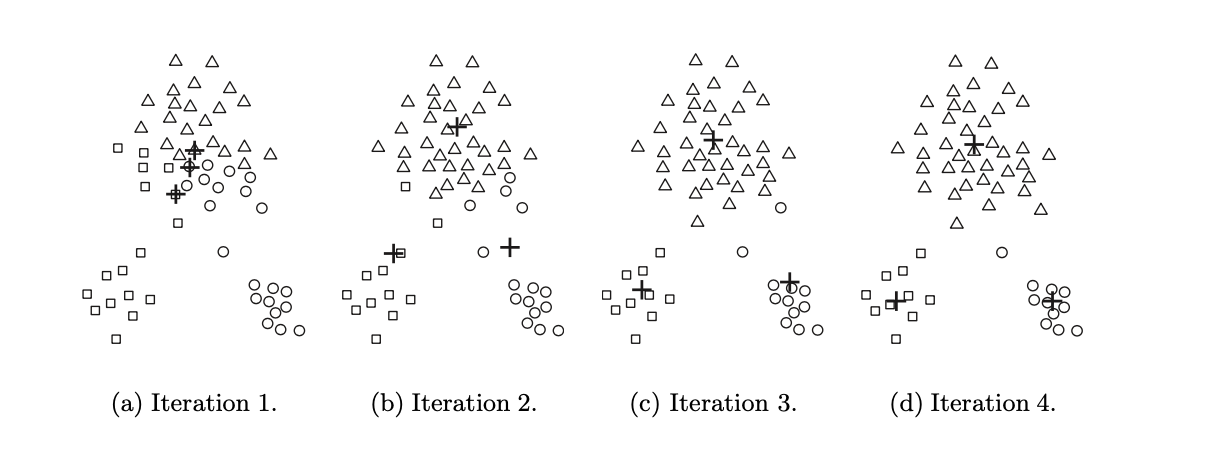


We chose Clustering Analysis and K-Means because we wanted to compare the difference between user segments, and their attitudes to each presidential candidate. After preliminary attempts to cluster using K-Means clustering we were unable to create clear and logical clusters and therefore we chose to create manual clusters based on followers. We created three groups: low group with 1000 followers or less, medium group with 1000 - 30 000 followers, and high group with 30 000 followers or more. We chose to divide them into groups to make it easier to visualize our data. We will focus on the medium and high group, and analyze the data based on sentiment analysis. This is because we believe that their tweets and message can have a greater chance of reaching more people. 

## 5.2 Sentiment analysis
Text classification is a method for handling text data or other information from databases and is used for research purposes. Its main function is to classify text into defined categories, or classes, based on its content and labels. These types of techniques for processing information can be applied to several fields, for instance document management or to filter emails. Therefore, the use of these techniques are extremely useful to access and handle information (Ur-Rahman & Harding, 2012).  

Sentiment analysis is a type of text classification where the main task is determining the sentiment of a text document by finding a correlation between the writer’s style and emotional state. In our case it will be the emotional state of the user’s tweet(s) posted on Twitter. The analysis considers the polarity of specific used keywords. The keywords’ polarity could be either positive, negative or neutral, for example “excellent”, “terrible” or “unbiased”. This technique is done by analyzing the contextual polarity of our collected tweets to categorize tweets about the two presidential candidates of the US Election 2020 into different emotional levels (Li et al. 2016).  

The sentiment analysis approach will be used in our project to analyze the extracted data from our dataset. We chose this data mining method because we hope to discover useful information to present and discuss by categorizing our text documents (tweets). This will make the evaluation process easier. To discover sentiments in tweets we find this technique useful in terms of categorizing the positive, negative and neutral words in users’ tweets posted around the US election 2020 (Ur-Rahman & Harding, 2012).

### 5.2.1 VADER
Valence Aware Dictionary and sEntiment Reasoner is a lexicon and rule-based sentiment tool that has been developed especially for social media texts. Not only does VADER tell us about positivity and negativity scores, but also how positive or negative the sentiment is. For example, when the word “good” appears with capital letters, the VADER tool will attach great importance to the fact that it is in capital letters, which means that “good” will have a greater positivity score. Also, VADER handles emojis and it’s expression. The tool is already a trained analysis, which means that training data are not required (Hutto C.J & Gilbert E.E, 2014).  

Based on the positive and negative scores we get from VADER, we can calculate a compound score. Compound scores can then be represented on a scale where -1 is the most extreme negative and 1 is the most positive value. This allows us to categorize the tweets sentiment into negative, positive and neutral groups. We chose to define the groups as follows, negative sentiment compound less than -0.05, positive sentiment compound more than 0.05, and neutral compound between -0.05 and 0.05. The VADER tool will be used in our project because it works well on social media, which is good in our case when we analyse texts from Twitter. Also, the tool is easy to use and we do not have to create any training data.  



# 6 Data analysis

In this section we will perform our analysis. We begin with some quick data exploration!

In [ ]:
sns.countplot(x="hashtag", data=tweets_all)
plt.show()

In the figure above we've plotted the number of tweets for each set of hashtags (trump/biden). We can observe that there are more tweets with the hashtag 'Trump' or 'DonaldTrump' than with 'Biden or 'JoeBiden'. Next up let's have compare the age of the twitter accounts for both hashtags as this might be interesting to compare!

In [ ]:
sns.displot(x='account_age',hue='hashtag' ,data=tweets_all)

The above plot, shows the distribution in account age for the two sets of hashtags. We can observe that they seem to be following very similar distribution.

## 6.1 Clustering
We initially attemted to create clusters using K-means clustering but we unfourtunatly unable to create meaningful clusters. We attemted to cluster of the variables; 'likes', 'retweet_count' and 'user_follower_count'. To still be able to move forward with our analyis we decided to create our clusters manually.

We created 6 clusters, three for each hashtag (trump/biden). And we based them on 'user_follower_clount' to keep it simple. We decided on the follwing boundaries:


*   Low amount of followers; less than 1000.
*   Medium amount of followers; more or equal to 1000 and less than 30000.
*   High amount of followers; more or equal to 30000.





In [ ]:
import seaborn as sns
sns.countplot(x="hashtag", data=tweets_all)
plt.show()

Skriv något om hur de skilljer sig åt i i antal

In [ ]:
low = tweets_all[tweets_all.user_followers_count < 1000]
med = tweets_all[(tweets_all.user_followers_count > 999) & (tweets_all.user_followers_count < 30000)]
high = tweets_all[tweets_all.user_followers_count > 29999] 



In [ ]:
print(low.user_followers_count.describe())

low_dist = sns.displot(low.user_followers_count)
plt.show()

low_count = sns.countplot(x="hashtag", data=low)
plt.show()

In [ ]:
print(med.user_followers_count.describe())

sns.displot(med.user_followers_count)
plt.show()

sns.countplot(x="hashtag", data=med)
plt.show()

In [ ]:
print(high.user_followers_count.describe())

sns.displot(high.user_followers_count)
plt.show()

sns.displot(high.user_followers_count,log_scale=True)
plt.show()

sns.countplot(x="hashtag", data=high)
plt.show()

In [ ]:
# We split the trump/biden datasets
low_trump = low[low.hashtag == 'trump']
low_biden = low[low.hashtag == 'biden']

med_trump = med[med.hashtag == 'trump']
med_biden = med[med.hashtag == 'biden']

high_trump = high[high.hashtag == 'trump']
high_biden = high[high.hashtag == 'biden']

## 6.2 Wordclouds

In [ ]:
### Trump wordclouds

print("Trump, low amout of followers")
plt.subplots(1,1, figsize=(9,9))
wc_low_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_low_t.generate((low_trump.cleaned_tweet.to_string()))
plt.imshow(wc_low_t, interpolation="bilinear")
plt.axis('off')
plt.show()
plt.title = "Trump, low amount of followers"
plt.clf()



print("Trump, medium amount of followers")
plt.subplots(1,1, figsize=(9,9))
wc_med_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_med_t.generate(med_trump.cleaned_tweet.to_string())
plt.imshow(wc_med_t, interpolation="bilinear")
plt.axis('off')
plt.show()
plt.clf()

print("Trump, high amount of followers")
plt.subplots(1,1, figsize=(9,9))
wc_high_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_high_t.generate(high_trump.cleaned_tweet.to_string())
plt.imshow(wc_low_t, interpolation="bilinear")
plt.axis('off')
plt.show()
plt.clf()

In [ ]:
print("Biden, low amount of followers")
plt.subplots(1,1, figsize=(9,9))
wc_low_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_low_b.generate(low_biden.cleaned_tweet.to_string())
plt.imshow(wc_low_b, interpolation="bilinear")
plt.axis('off')
plt.show()
plt.clf()

print("Biden, medium amount of followers")
plt.subplots(1,1, figsize=(9,9))
wc_med_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_med_b.generate(med_biden.cleaned_tweet.to_string())
plt.imshow(wc_med_b, interpolation="bilinear")
plt.axis('off')
plt.show()

print("Biden, high amount of followers")
plt.clf()
plt.subplots(1,1, figsize=(9,9))
wc_high_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=250,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_high_b.generate(high_biden.cleaned_tweet.to_string())
plt.imshow(wc_low_t, interpolation="bilinear")
plt.axis('off')
plt.show()


## 6.3 Sentiment analyis  
Let's analyse the sentiment of the tweets in each of our clusters.


In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()



# Calculate biden scores
low_biden['scores'] = low_biden['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
med_biden['scores'] = med_biden['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
high_biden['scores'] = high_biden['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

# Calculate trump scores
low_trump['scores'] = low_trump['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
med_trump['scores'] = med_trump['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))
high_trump['scores'] = high_trump['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

In [ ]:
# Create seperate column for compund score
low_biden['compound']  = low_biden['scores'].apply(lambda score_dict: score_dict['compound'])
med_biden['compound']  = med_biden['scores'].apply(lambda score_dict: score_dict['compound'])
high_biden['compound']  = high_biden['scores'].apply(lambda score_dict: score_dict['compound'])

low_trump['compound']  = low_trump['scores'].apply(lambda score_dict: score_dict['compound'])
med_trump['compound']  = med_trump['scores'].apply(lambda score_dict: score_dict['compound'])
high_trump['compound']  = high_trump['scores'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
# Create column with sentiment with the following rules:
# positive: if compound > 0.05
# netural: if compound <=0.05 and >=-0.05
# negtaive: if compound <-0.05
def compound_to_sentiment(compound):
  if compound > 0.05:
    return "pos"
  elif compound < -0.05: 
    return "neg"
  else: 
    return "neu"

# Create seperate column for sentiment
low_biden['sentiment'] = low_biden['compound'].apply(lambda score: compound_to_sentiment(score))
med_biden['sentiment'] = med_biden['compound'].apply(lambda score: compound_to_sentiment(score))
high_biden['sentiment'] = high_biden['compound'].apply(lambda score: compound_to_sentiment(score))

low_trump['sentiment'] = low_trump['compound'].apply(lambda score: compound_to_sentiment(score))
med_trump['sentiment'] = med_trump['compound'].apply(lambda score: compound_to_sentiment(score))
high_trump['sentiment'] = high_trump['compound'].apply(lambda score: compound_to_sentiment(score))

In [ ]:
fig, axe = plt.subplots(2,3, sharey=True, figsize=(20,10))
sns.histplot(low_biden.compound, ax=axe[0][0],stat="density" ).set_title('Biden, low')
sns.histplot(med_biden.compound, ax=axe[0][1],stat="density").set_title('Biden, med')
sns.histplot(high_biden.compound, ax=axe[0][2],stat="density").set_title('Biden, high')

sns.histplot(low_trump.compound, ax=axe[1][0],stat="density").set_title('Trump, low')
sns.histplot(med_trump.compound, ax=axe[1][1],stat="density").set_title('Trump, med')
sns.histplot(high_trump.compound, ax=axe[1][2],stat="density").set_title('Trump, high')

plt.show()
plt.clf()


In [ ]:
# Percentage of neg, neu & pos in each cluster
fig, axe = plt.subplots(2,3, sharey=True, figsize=(20,10))
axe[0][0] = sns.barplot(x=low_biden.sentiment.value_counts().index, y=low_biden.sentiment.value_counts()/len(low_biden), order=['neg','neu','pos'], ax=axe[0][0]).set_title('Biden, low')
axe[0][1] = sns.barplot(x=med_biden.sentiment.value_counts().index, y=med_biden.sentiment.value_counts()/len(med_biden), order=['neg','neu','pos'], ax=axe[0][1]).set_title('Biden, med')
axe[0][2] = sns.barplot(x=high_biden.sentiment.value_counts().index, y=high_biden.sentiment.value_counts()/len(high_biden), order=['neg','neu','pos'], ax=axe[0][2]).set_title('Biden, high')

axe[1][0] =  sns.barplot(x=low_trump.sentiment.value_counts().index, y=low_trump.sentiment.value_counts()/len(low_trump), order=['neg','neu','pos'], ax=axe[1][0]).set_title('Trump, low')
axe[1][1] = sns.barplot(x=med_trump.sentiment.value_counts().index, y=med_trump.sentiment.value_counts()/len(med_trump), order=['neg','neu','pos'], ax=axe[1][1]).set_title('Trump, med')
axe[1][2] = sns.barplot(x=high_trump.sentiment.value_counts().index, y=high_trump.sentiment.value_counts()/len(high_trump), order=['neg','neu','pos'], ax=axe[1][2]).set_title('Trump, high')
plt.show()
plt.clf()

In [ ]:
# Absolute number of neg,neu & pos in each cluster Note that they do not share y-axises
fig, axe = plt.subplots(2,3, figsize=(20,10),sharey=True)
axe[0][0] = sns.countplot(x=low_biden.sentiment, ax=axe[0][0],order=['neg','neu','pos']).set_title('Biden, low')
axe[0][1] = sns.countplot(x=med_biden.sentiment, ax=axe[0][1],order=['neg','neu','pos']).set_title('Biden, med')
axe[0][2] = sns.countplot(x=high_biden.sentiment, ax=axe[0][2],order=['neg','neu','pos']).set_title('Biden, high')

axe[1][0] = sns.countplot(x=low_trump.sentiment,ax=axe[1][0],order=['neg','neu','pos']).set_title('Trump, low')
axe[1][1] = sns.countplot(x=med_trump.sentiment,ax=axe[1][1],order=['neg','neu','pos']).set_title('Trump, med')
axe[1][2] = sns.countplot(x=high_trump.sentiment,ax=axe[1][2],order=['neg','neu','pos']).set_title('Trump, high')
plt.show()
plt.clf()

# 7 Evaluation of results

In this section we will analyze our findings from the previous section.

## 7.1 Analysis of results
Our primary idea was to create distinct clusters by using K-Means and Cluster analysis. Early in our pre-processing phase, we discovered that “popularity” is challenging to define. With likes and followers, our data displayed a lot of value in one direction and less in the other. Also, the majority of tweets get few or no likes and retweets at all. Therefore, the K-Means method did not provide us with any useful information. Instead, we redefined “popularity” as the amount of followers the twitter user has. Afterwards, we continued to analyze if there’s any difference between users’ sentiment towards the presidential candidates depending on the number of followers.  


## 7.2 Critique of dataset
The processing of our data has given us a lot of useful information for our sentiment analysis. Though, there are a few aspects to be critical of when evaluating the results and presenting our conclusion. Sentiment analysis is a complex process and could be challenging if the text documents in question are complicated. The data in tweets could be difficult to interpret, like the wrongful use of hashtags or if the choice of words sends the wrong message in terms of being positive, negative or neutral. For example, when a tweet speaks poorly of a presidential candidate but is followed with a hashtag for the opposite candidate, the tweet will be processed as a negative tweet for the opposite candidate even if this wasn’t the intention of the tweet itself. Hence, we’ve lost the semantic meaning of tweets in our analysis since our data mining method can’t take this into consideration.  
 
Even with the use of VADER and its benefits, another aspect is the irony found in certain tweets. This too is about the semantics in tweets, which is very difficult for a computer to comprehend. We found that tweets that were sarcastic in their opinions created a challenge for the computer to categorize them accurately. The more irony used in tweets, the more negative impact it has on the results.


## 7.3 Conclusion of results
In our hypothesis we thought that tweets regarding Trump would be more positive towards Trump than Biden. The result of our sentiment analysis indicated that there is no substantial difference between the two presidential candidates, which doesn’t correlate with our hypothesis. This is a positive outcome for the Democratic Party who believed that Trump dominated on Twitter. The fact that the analysis indicates an equal result is also reflected on the outcome of the election itself, where the number of votes were extremely equal between the two candidates.  

To answer our research question, we can see that the difference between the two clusters is not as great as we previously thought. Our sentiment analysis did provide us with new information, for example that tweets regarding Biden were more positive than what we had predicted. The results of this study are in favor of what hoped to deliver to the Democratic Party. They have been provided with a study that shows that they are in fact reaching out to voters through the social media platform Twitter, and that they can (and should) continue to communicate via Twitter. This study has presented and discussed the great impact of the usage of social media platforms for communicating with voters and generating sentiment towards a political party and its presidential candidate. We hope that the Democratic Party will find this study useful for future campaigning.


# 8. Ethical aspects

When an organization is processing users’ personal information, it’s important to consider the ethical aspects. Since Twitter is an organization that uses this type of data, they have a responsibility to process the data in a correct and ethical way. When we initialized our project we’ve had to take ethics into consideration as well because Twitter is the source of our dataset. Also, since our project is launched in Sweden, we have to follow the european General Data Protection Regulation (GDPR). This means processing the data in a correct way in relation to this law (Dryselius, n.d.). 

Twitter’s privacy policy can be found on their official website. When using Twitter in any way, they receive information about the user in terms of what device the user is on and its IP address. It’s also possible to share additional information to Twitter when creating an account, e.g. an email, phone number or location. In contrast, the user can change their settings and limit the amount of data that Twitter collects and how they use it (Williams et al. 2017). Twitter will also use information about users to find more relevant tweets, people to follow, and personalized ads. By looking at the tweets, likes, and retweets of a user, Twitter can determine a lot about the users’ personality. For instance, topics you’re interested in, and languages you speak and/or comprehend (Williams et al. 2017).  

When pre-processing our dataset, we follow the guidelines of GDPR. This implies that we have the consent of the Twitter users to use their information. This consent is granted through Twitter’s own website when users accept their terms and conditions at the point of registration. Since the main purpose of this study is to examine different levels of sentiments in tweets, we don’t process the personal data about the actual users. Therefore, the information extracted from this analysis is not harmful to users from an ethical standpoint. This information is filtered out at an early stage in our project and is not used in the sentiment analysis. Though, there are a few other ethical aspects to consider.  

For instance, conducting this type of analysis on data could hinder the principle of free speech. The fact that studying twitter data has become a highly popular research area, more people are becoming aware that they’re under surveillance.  Expressing strong opinions, in this case about politics, could affect the users’ content in terms of feed, ads, people to follow etc. The effect this could have is the limitation of peoples’ transparent opinions on Twitter and lead to a negative impact on the social media industry as whole.  

Another aspect is the bias of the analysis. People can make more subjective decisions than computers can. This means that despite the fact that computers can make objective decisions, it’s still indirectly subjective if a human being provides the basis of it. In order to preprocess our data and evaluate the results, several decisions have to be taken by people and therefore the data will be biased. With this process, information that could be of value will be left out without us knowing. 


# 9. Project plan

Our project is based on the open standard process model for data mining, CRoss-Industry Standard Process for Data Mining (CRISP-DM). The model is an ongoing, iterative cycle and mainly consists of six different phases. 

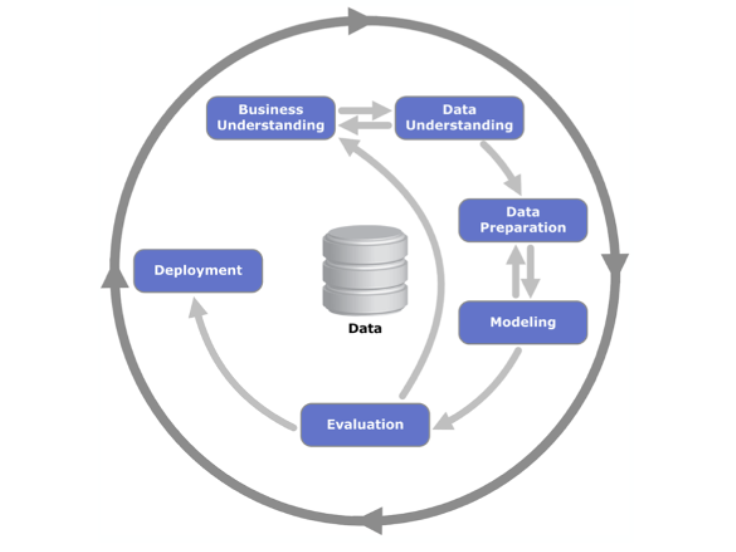

## 9.1 Business understanding
The first step is to understand the Business, in this case The Democratic Party. To understand the party we need to determine their business objectives, assess their situation, determine data mining goals and produce a plan for the project (Kelly A et. al, 2020). After understanding the business, we need to convert this knowledge to a definition of a data mining problem. 



## 9.2 Data understanding
The purpose of the second step is to understand data and by collecting, describing, exploring and verifying the quality of the data (Kelly A et.al, 2020). After processing the data, we became more familiar with the data. This allowed us to answer our research question, and filter out data that we previously thought was relevant. 

## 9.3 Data preparation
In this section we select, clean, integrate and format our dataset (Kelly A et.al, 2020). To clean our dataset we removed digits, small words, duplicates, words with less than 3 characters, links, emojis, reserved twitter words and all mentions. We also made our dataset only to process lower cases words. This helped us for subsequent analyses and testing. 

## 9.4 Modeling 

The fourth step is the modeling step where you select techniques for modeling and generate models and thereafter assess the model (Kelly A et.al, 2020). The techniques that we used for modeling our dataset was first manual clustering, where we divided our dataset into three different groups depending on the number of followers. Thereafter we used sentiment analysis to analyze the tweets from the different groups. Also, we visualize the tweets with a word cloud to determine which words that are used frequently in the tweets and plots.

## 9.5 Evaluation
This step is followed by evaluation, where the result is evaluated and reviewed (Kelly A et.al, 2020). The evulation part was neither too difficult nor time-consuming, this is because the previous two steps have been done properly. Our results were distinct and easy to evaluate.

## 9.6 Deployment
The sixth and final step focuses on planning the deployment and maintenance (Kelly A et.al, 2020). One aspect that can be looked at during this final step is maintenance, this depends on what the result indicates and if the results can be something that we can maintain. 